<a href="https://colab.research.google.com/github/hobezhang/NLP-based-information-retrieval-system/blob/main/SPLADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = ['The sun sets over the horizon, painting the sky in warm hues.',
          'In a bustling city, people hurry to their workplaces in the early morning.',
          'A melody from a distant guitar fills the air on a quiet evening.',
          'Exploring the pages of a captivating novel, lost in a world of imagination.',
          'Raindrops tap gently on the window pane, creating a soothing rhythm.'
         ]

# 定义用于预处理文本的函数
def preprocess_text(text):
    # 移除标点符号和其他非字母数字字符
    text =  re.sub('[^a-zA-Z]', ' ', text)
    # 将文本标记化为单词
    words = word_tokenize(text.lower())
    # 移除停用词
    words = [word for word in words if word not in stopwords.words('english')]
    # print(stopwords.words('english'))
    # 将单词重新连接成字符串
    return ' '.join(words)

# 预处理样例文档
corpus = [preprocess_text(doc) for doc in corpus]
print('文档集: \n{}'.format(corpus))

# 创建一个 TfidfVectorizer 对象并将其拟合到预处理的文档集
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

# 获取与 TF-IDF 矩阵中的列对应的特征名称列表
print("特征名称:\n", vectorizer.get_feature_names_out())

# 将预处理的文档集转换为 TF-IDF 矩阵
tf_idf_matrix = vectorizer.transform(corpus)

# 打印生成的矩阵
print()
print(tf_idf_matrix)
print("TF-IDF 矩阵:\n",tf_idf_matrix.toarray())


文档集: 
['sun sets horizon painting sky warm hues', 'bustling city people hurry workplaces early morning', 'melody distant guitar fills air quiet evening', 'exploring pages captivating novel lost world imagination', 'raindrops tap gently window pane creating soothing rhythm']
特征名称:
 ['air' 'bustling' 'captivating' 'city' 'creating' 'distant' 'early'
 'evening' 'exploring' 'fills' 'gently' 'guitar' 'horizon' 'hues' 'hurry'
 'imagination' 'lost' 'melody' 'morning' 'novel' 'pages' 'painting' 'pane'
 'people' 'quiet' 'raindrops' 'rhythm' 'sets' 'sky' 'soothing' 'sun' 'tap'
 'warm' 'window' 'workplaces' 'world']

  (0, 32)	0.3779644730092272
  (0, 30)	0.3779644730092272
  (0, 28)	0.3779644730092272
  (0, 27)	0.3779644730092272
  (0, 21)	0.3779644730092272
  (0, 13)	0.3779644730092272
  (0, 12)	0.3779644730092272
  (1, 34)	0.3779644730092272
  (1, 23)	0.3779644730092272
  (1, 18)	0.3779644730092272
  (1, 14)	0.3779644730092272
  (1, 6)	0.3779644730092272
  (1, 3)	0.3779644730092272
  (1, 1)	0.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
import math

class BM25:
    def __init__(self, corpus, k1=1.5, b=0.75):
        """

        参数：
        - corpus: 文档集合，每个文档应该是一个单词列表
        - k1: 一个调节参数，控制词项频率对得分的影响
        - b: 一个调节参数，控制文档长度对得分的影响
        """
        self.corpus = corpus
        self.k1 = k1
        self.b = b
        self.doc_lengths = [len(doc) for doc in corpus]
        self.avg_doc_length = sum(self.doc_lengths) / len(corpus)
        self.doc_count = len(corpus)
        self.idf = self.calculate_idf()

    def calculate_idf(self):
        """
        计算每个词项的逆文档频率（IDF）

        返回一个字典，其中键是词项，值是对应的IDF值
        """
        idf = {}
        for doc in self.corpus:
            unique_terms = set(doc)
            for term in unique_terms:
                idf[term] = idf.get(term, 0) + 1

        for term in idf:
            idf[term] = math.log((self.doc_count - idf[term] + 0.5) / (idf[term] + 0.5) + 1.0)

        return idf

    def calculate_score(self, query, doc):
        """
        计算查询与文档之间的BM25得分

        参数：
        - query: 查询词项列表
        - doc: 文档词项列表

        返回BM25得分
        """
        score = 0.0

        for term in query:
            if term in doc:
                df = sum([1 for d in self.corpus if term in d])
                idf_term = self.idf.get(term, 0)
                score += (idf_term * doc.count(term) * (self.k1 + 1)) / (
                        doc.count(term) + self.k1 * (1 - self.b + self.b * len(doc) / self.avg_doc_length))
                score *= df / (df + 1)  # length normalization

        return score

    def rank_documents(self, query):
        """
        对文档进行排名，返回排名后的文档列表和对应的BM25得分

        参数：
        - query: 查询词项列表

        返回排名后的文档索引列表和对应的BM25得分
        """
        scores = [(i, self.calculate_score(query, self.corpus[i])) for i in range(self.doc_count)]
        ranked_docs = sorted(scores, key=lambda x: x[1], reverse=True)
        return [(doc[0], doc[1]) for doc in ranked_docs]


# 示例用法
corpus = [
    ["apple", "banana", "orange", "apple"],
    ["banana", "orange", "orange","apple"],
    ["apple", "apple", "banana"]
]

query = ["apple", "orange"]

bm25_model = BM25(corpus)
result = bm25_model.rank_documents(query)
print("排名后的文档索引和BM25得分：", result)


排名后的文档索引和BM25得分： [(1, 0.499055695673375), (0, 0.39369287621150584), (2, 0.15194951574514637)]


SPLADE

In [63]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

model_id = 'naver/splade-cocondenser-ensembledistil'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

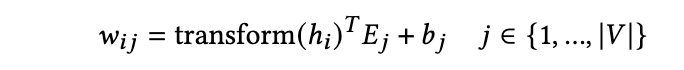

In [64]:
tokens = tokenizer("The dogs like fishes.", return_tensors='pt')
output = model(**tokens)
print(output)
output.logits.shape

MaskedLMOutput(loss=None, logits=tensor([[[ -6.0706,  -8.1703,  -7.2440,  ...,  -7.9876,  -7.7427,  -6.0149],
         [ -6.3226,  -8.1456,  -7.3569,  ...,  -8.1020,  -7.7092,  -6.4092],
         [-26.6736, -20.8495, -20.1078,  ..., -20.8740, -19.0471, -22.1640],
         ...,
         [-21.1708, -17.7811, -14.9942,  ..., -17.3077, -17.3838, -18.2990],
         [-17.6253, -15.1335, -14.2484,  ..., -14.8527, -13.7333, -15.2855],
         [-17.4875, -15.0432, -14.2110,  ..., -14.7886, -13.7254, -15.2659]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)


torch.Size([1, 7, 30522])

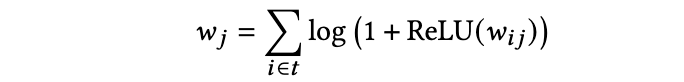

In [65]:
import torch

vec = torch.max(
    torch.log(
        1 + torch.relu(output.logits)
    ) * tokens.attention_mask.unsqueeze(-1),
dim=1).values.squeeze()


In [66]:
vec

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [67]:
print(len(vec))

30522


In [70]:

cols = vec.nonzero().squeeze().cpu().tolist()
print(len(cols))


weights = vec[cols].cpu().tolist()

sparse_dict = dict(zip(cols, weights))
sparse_dict

47


{1024: 0.32549533247947693,
 1996: 0.13122345507144928,
 2027: 0.5024433732032776,
 2066: 1.8275704383850098,
 2123: 0.0026553154457360506,
 2215: 0.6085314750671387,
 2298: 0.0978935956954956,
 2300: 0.058600787073373795,
 2427: 0.12191428244113922,
 2748: 0.05803355574607849,
 3869: 2.252826452255249,
 3899: 2.578550338745117,
 4111: 0.5009176135063171,
 4153: 0.288269966840744,
 4176: 0.2985146939754486,
 4521: 0.7205613851547241,
 4669: 1.0484800338745117,
 4743: 0.18439070880413055,
 5074: 0.03130869194865227,
 5248: 0.6992034912109375,
 5437: 0.23216351866722107,
 5438: 0.13832789659500122,
 5532: 0.4857371151447296,
 5645: 1.7455503940582275,
 5742: 0.6806011199951172,
 5875: 0.28323766589164734,
 5933: 0.31160733103752136,
 6077: 2.5794031620025635,
 6240: 0.00956618133932352,
 6805: 0.2515466511249542,
 6816: 0.15462760627269745,
 7488: 0.07079310715198517,
 7529: 0.0016862234333530068,
 8843: 0.3176485002040863,
 9004: 0.2862841486930847,
 9201: 0.19111385941505432,
 9544: 0.

In [71]:
# extract the ID position to text token mappings
idx2token = {
    idx: token for token, idx in tokenizer.get_vocab().items()
}
# map token IDs to human-readable tokens
sparse_dict_tokens = {
    idx2token[idx]: round(weight, 2) for idx, weight in zip(cols, weights)
}
# sort so we can see most relevant tokens first
sparse_dict_tokens = {
    k: v for k, v in sorted(
        sparse_dict_tokens.items(),
        key=lambda item: item[1],
        reverse=True
    )
}
sparse_dict_tokens

#Caravanserais were roadside inns that were built along the Silk Road in areas including China, North Africa and the Middle East.

{'dog': 2.58,
 'dogs': 2.58,
 'fishes': 2.34,
 'fish': 2.25,
 'like': 1.83,
 'fishing': 1.75,
 'liked': 1.05,
 'eat': 0.72,
 'behavior': 0.7,
 'swimming': 0.68,
 'want': 0.61,
 'prefer': 0.52,
 'they': 0.5,
 'animal': 0.5,
 'desert': 0.49,
 'shark': 0.34,
 ':': 0.33,
 'breed': 0.32,
 'hunting': 0.31,
 'animals': 0.3,
 'ocean': 0.29,
 'pet': 0.29,
 'interesting': 0.28,
 'bite': 0.25,
 'smell': 0.23,
 'zoo': 0.19,
 'attract': 0.19,
 'catfish': 0.19,
 'bird': 0.18,
 'predator': 0.18,
 'tiger': 0.15,
 'feed': 0.14,
 'the': 0.13,
 'species': 0.12,
 'look': 0.1,
 'swim': 0.09,
 'bully': 0.08,
 'parasite': 0.08,
 'snake': 0.07,
 'water': 0.06,
 'yes': 0.06,
 'roger': 0.03,
 'aggression': 0.03,
 'meat': 0.01,
 'dolphin': 0.01,
 'don': 0.0,
 '##fish': 0.0}

In [72]:
texts = [
    "Caravanserais were also an important marketplace for commodities",
    "From the 10th century onwards,as merchant and travel routes become more developed",
    "Photosynthesis is the process of storing light energy as chemical energy in cells",
]

In [74]:
tokens = tokenizer(
    texts, return_tensors='pt',
    padding=True, truncation=True
)
output = model(**tokens)
# aggregate the token-level vecs and transform to sparse
vecs = torch.max(
    torch.log(1 + torch.relu(output.logits)) * tokens.attention_mask.unsqueeze(-1), dim=1
).values.squeeze().detach().cpu().numpy()
vecs.shape

(3, 30522)

In [75]:
import numpy as np

sim = np.zeros((vecs.shape[0], vecs.shape[0]))

for i, vec in enumerate(vecs):
    sim[i,:] = np.dot(vec, vecs.T) / (
        np.linalg.norm(vec) * np.linalg.norm(vecs, axis=1)
    )
sim.round(decimals=2)

array([[1.  , 0.13, 0.  ],
       [0.13, 1.  , 0.  ],
       [0.  , 0.  , 1.  ]])